In [12]:
import pandas as pd

# --- API endpoints ---
url_speeds_2023 = "https://data.ny.gov/resource/58t6-89vi.json"
url_speeds_2025 = "https://data.ny.gov/resource/kufs-yh3x.json"
url_ace = "https://data.ny.gov/resource/kh8p-hcbm.json"

# --- CUNY routes of interest ---
cuny_routes = ["BX40", "BX12", "Q25", "BX42", "M101", "B49", "B6"]

# --- Load bus speeds (2023–2024) ---
speeds_2023 = pd.read_json(f"{url_speeds_2023}?$select=route_id,average_road_speed&$limit=500000")
speeds_2023 = speeds_2023[speeds_2023["route_id"].isin(cuny_routes)]
speeds_2023["average_road_speed"] = pd.to_numeric(speeds_2023["average_road_speed"], errors="coerce")
avg_2023 = speeds_2023.groupby("route_id", as_index=False)["average_road_speed"].mean()
avg_2023.rename(columns={"average_road_speed": "speed_2023"}, inplace=True)

# --- Load bus speeds (2025) ---
speeds_2025 = pd.read_json(f"{url_speeds_2025}?$select=route_id,average_road_speed&$limit=500000")
speeds_2025 = speeds_2025[speeds_2025["route_id"].isin(cuny_routes)]
speeds_2025["average_road_speed"] = pd.to_numeric(speeds_2025["average_road_speed"], errors="coerce")
avg_2025 = speeds_2025.groupby("route_id", as_index=False)["average_road_speed"].mean()
avg_2025.rename(columns={"average_road_speed": "speed_2025"}, inplace=True)

# --- Load ACE enforcement info ---
ace = pd.read_json(f"{url_ace}?$select=bus_route_id,first_occurrence&$limit=500000")
ace = ace[ace["bus_route_id"].isin(cuny_routes)]
ace_min = ace.groupby("bus_route_id", as_index=False)["first_occurrence"].min()
ace_min.rename(columns={"bus_route_id": "route_id", "first_occurrence": "enforcement_start"}, inplace=True)

# --- Merge everything ---
merged = avg_2023.merge(avg_2025, on="route_id", how="outer").merge(ace_min, on="route_id", how="left")

# --- Compute speed change and percent change ---
merged["delta"] = merged["speed_2025"] - merged["speed_2023"]
merged["percent_change"] = (merged["delta"] / merged["speed_2023"]) * 100

# --- Print results in comprehensive words ---
print("=== 🚍 CUNY Bus Routes: Speed Changes After ACE Enforcement ===\n")
for _, row in merged.iterrows():
    route = row["route_id"]
    s2023 = round(row["speed_2023"], 2) if pd.notna(row["speed_2023"]) else "N/A"
    s2025 = round(row["speed_2025"], 2) if pd.notna(row["speed_2025"]) else "N/A"
    delta = round(row["delta"], 2) if pd.notna(row["delta"]) else "N/A"
    pct = round(row["percent_change"], 2) if pd.notna(row["percent_change"]) else "N/A"
    enforcement = row["enforcement_start"] if pd.notna(row["enforcement_start"]) else None
    
    if enforcement:
        print(f"Route {route}: average speed changed by {delta} mph ({pct}%) (from {s2023} → {s2025}) after ACE enforcement (since {enforcement}).")
    else:
        print(f"Route {route}: NO ACE enforcement recorded — change {delta} mph ({pct}%) (from {s2023} → {s2025}).")


=== 🚍 CUNY Bus Routes: Speed Changes After ACE Enforcement ===

Route B49: NO ACE enforcement recorded — change 0.15 mph (1.76%) (from 8.4 → 8.55).
Route B6: NO ACE enforcement recorded — change -0.55 mph (-6.79%) (from 8.15 → 7.6).
Route BX12: NO ACE enforcement recorded — change 1.78 mph (30.21%) (from 5.88 → 7.66).
Route BX40: NO ACE enforcement recorded — change 2.04 mph (35.78%) (from 5.72 → 7.76).
Route BX42: NO ACE enforcement recorded — change 0.32 mph (4.42%) (from 7.35 → 7.68).
Route M101: average speed changed by 0.21 mph (3.23%) (from 6.53 → 6.74) after ACE enforcement (since 2025-05-07T12:52:15.000).
Route Q25: NO ACE enforcement recorded — change 0.43 mph (5.83%) (from 7.4 → 7.84).


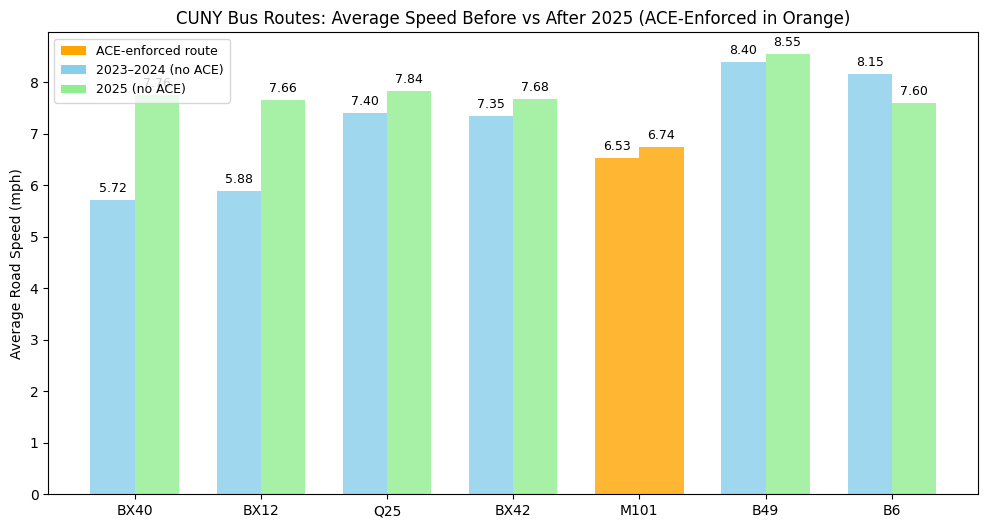

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# Sort by route for consistent order
merged_sorted = merged.set_index("route_id").loc[cuny_routes]

# Bar positions
x = np.arange(len(cuny_routes))
width = 0.35

# Colors: highlight ACE-enforced routes
colors_2023 = ['orange' if pd.notna(row) else 'skyblue' for row in merged_sorted["enforcement_start"]]
colors_2025 = ['orange' if pd.notna(row) else 'lightgreen' for row in merged_sorted["enforcement_start"]]

plt.figure(figsize=(12,6))
bars_2023 = plt.bar(x - width/2, merged_sorted["speed_2023"], width, color=colors_2023, alpha=0.8)
bars_2025 = plt.bar(x + width/2, merged_sorted["speed_2025"], width, color=colors_2025, alpha=0.8)

# Annotate bars with exact speed values
for i in range(len(cuny_routes)):
    plt.text(x[i] - width/2, merged_sorted["speed_2023"].iloc[i] + 0.1,
             f"{merged_sorted['speed_2023'].iloc[i]:.2f}", ha='center', va='bottom', fontsize=9)
    plt.text(x[i] + width/2, merged_sorted["speed_2025"].iloc[i] + 0.1,
             f"{merged_sorted['speed_2025'].iloc[i]:.2f}", ha='center', va='bottom', fontsize=9)

plt.xticks(x, cuny_routes)
plt.ylabel("Average Road Speed (mph)")
plt.title("CUNY Bus Routes: Average Speed Before vs After 2025 (ACE-Enforced in Orange)")

# Custom legend with smaller box
legend_elements = [
    Patch(facecolor='orange', label='ACE-enforced route'),
    Patch(facecolor='skyblue', label='2023–2024 (no ACE)'),
    Patch(facecolor='lightgreen', label='2025 (no ACE)')
]
plt.legend(handles=legend_elements, fontsize=9, frameon=True, borderpad=0.5, labelspacing=0.5, loc='upper left')

plt.show()


In [33]:
import pandas as pd

# --- API endpoints ---
url_speeds_2023 = "https://data.ny.gov/resource/58t6-89vi.json"
url_speeds_2025 = "https://data.ny.gov/resource/kufs-yh3x.json"
url_ace = "https://data.ny.gov/resource/kh8p-hcbm.json"

# --- CUNY routes of interest ---
cuny_routes = ["BX40", "BX12", "Q25", "BX42", "M101", "B49", "B6"]

# --- Load bus speeds (2023–2024) ---
speeds_2023 = pd.read_json(
    f"{url_speeds_2023}?$select=route_id,timepoint_stop_id,average_road_speed&$limit=500000"
)
speeds_2023 = speeds_2023[speeds_2023["route_id"].isin(cuny_routes)].copy()
speeds_2023["average_road_speed"] = pd.to_numeric(
    speeds_2023["average_road_speed"], errors="coerce"
)

# --- Load bus speeds (2025) ---
speeds_2025 = pd.read_json(
    f"{url_speeds_2025}?$select=route_id,timepoint_stop_id,average_road_speed&$limit=500000"
)
speeds_2025 = speeds_2025[speeds_2025["route_id"].isin(cuny_routes)].copy()
speeds_2025["average_road_speed"] = pd.to_numeric(
    speeds_2025["average_road_speed"], errors="coerce"
)

# --- Merge by route + stop ---
merged_speeds = pd.merge(
    speeds_2023, speeds_2025, on=["route_id", "timepoint_stop_id"], suffixes=("_2023", "_2025")
)

# --- Load ACE enforcement info ---
ace = pd.read_json(f"{url_ace}?$select=bus_route_id,stop_id&$limit=500000")
ace = ace[ace["bus_route_id"].isin(cuny_routes)].copy()
ace_counts = ace.groupby(["bus_route_id", "stop_id"]).size().reset_index(name="violation_count")
ace_counts.rename(columns={"bus_route_id": "route_id", "stop_id": "timepoint_stop_id"}, inplace=True)

# --- Merge speeds with ACE violations ---
merged_hotspots = pd.merge(
    merged_speeds, ace_counts, on=["route_id", "timepoint_stop_id"], how="left"
)
merged_hotspots["violation_count"] = merged_hotspots["violation_count"].fillna(0)

# --- Compute speed change ---
merged_hotspots["speed_delta"] = (
    merged_hotspots["average_road_speed_2025"] - merged_hotspots["average_road_speed_2023"]
)

# --- Filter extreme deltas or invalid data ---
merged_hotspots_clean = merged_hotspots[
    (merged_hotspots["average_road_speed_2023"] > 0) &
    (merged_hotspots["average_road_speed_2025"] > 0) &
    (merged_hotspots["speed_delta"].abs() < 50)
]

# --- Only stops with violations ---
merged_hotspots_violation = merged_hotspots_clean[merged_hotspots_clean["violation_count"] > 0]

# --- Route-level summary using groupby.agg to avoid FutureWarning ---
route_summary = merged_hotspots_violation.groupby("route_id").agg(
    high_violation_locations=("timepoint_stop_id", "count"),
    slowdowns=("speed_delta", lambda x: (x < 0).sum()),
    speedups=("speed_delta", lambda x: (x > 0).sum()),
    avg_delta_high_violation=("speed_delta", "mean")
).reset_index()

# --- Sort by average slowdown ---
route_summary_sorted = route_summary.sort_values(by="avg_delta_high_violation")

# --- Print textual summary ---
print("=== Route-Level Ranking by Avg Slowdown at High-Violation Locations ===")
for i, row in enumerate(route_summary_sorted.itertuples(), 1):
    route = row.route_id
    avg_delta = round(row.avg_delta_high_violation, 2)
    total = row.high_violation_locations
    slow = row.slowdowns
    fast = row.speedups
    highlight = " ← TOP 3 MOST AFFECTED" if i <= 3 else ""
    print(f"Route {route}: {total} high-violation locations → {slow} slowdowns, {fast} speedups, avg delta {avg_delta} mph{highlight}.")

# --- Overall insight ---
overall_avg_delta = merged_hotspots_violation["speed_delta"].mean()
if overall_avg_delta < 0:
    overall = "Overall, bus stops with the highest violation counts tend to experience slowdowns."
elif overall_avg_delta > 0:
    overall = "Overall, bus stops with the highest violation counts tend to experience slight speed increases."
else:
    overall = "Overall, bus stops with the highest violation counts show no significant speed change."
print(f"\nOverall Insight: {overall}")


=== Route-Level Ranking by Avg Slowdown at High-Violation Locations ===
Route M101: 1090777 high-violation locations → 568459 slowdowns, 522314 speedups, avg delta -0.09 mph ← TOP 3 MOST AFFECTED.

Overall Insight: Overall, bus stops with the highest violation counts tend to experience slowdowns.


In [54]:
import pandas as pd

# --- API endpoints ---
url_speeds_2023 = "https://data.ny.gov/resource/58t6-89vi.json"
url_speeds_2025 = "https://data.ny.gov/resource/kufs-yh3x.json"
url_ace = "https://data.ny.gov/resource/kh8p-hcbm.json"

# --- CUNY routes of interest ---
cuny_routes = ["BX40", "BX12", "Q25", "BX42", "M101", "B49", "B6"]

# --- Load bus speeds ---
speeds_2023 = pd.read_json(
    f"{url_speeds_2023}?$select=route_id,timepoint_stop_id,average_road_speed&$limit=500000"
)
speeds_2023 = speeds_2023[speeds_2023["route_id"].isin(cuny_routes)].copy()
speeds_2023["average_road_speed"] = pd.to_numeric(speeds_2023["average_road_speed"], errors="coerce")

speeds_2025 = pd.read_json(
    f"{url_speeds_2025}?$select=route_id,timepoint_stop_id,average_road_speed&$limit=500000"
)
speeds_2025 = speeds_2025[speeds_2025["route_id"].isin(cuny_routes)].copy()
speeds_2025["average_road_speed"] = pd.to_numeric(speeds_2025["average_road_speed"], errors="coerce")

# --- Merge by route + stop ---
merged_speeds = pd.merge(
    speeds_2023, speeds_2025, on=["route_id", "timepoint_stop_id"], suffixes=("_2023", "_2025")
)

# --- Load ACE enforcement info ---
ace = pd.read_json(f"{url_ace}?$select=bus_route_id,stop_id,violation_latitude,violation_longitude,violation_id&$limit=500000")
ace = ace[ace["bus_route_id"].isin(cuny_routes)].copy()

# --- Aggregate violations per stop (memory-safe) ---
hotspots_agg = ace.groupby(["bus_route_id", "stop_id"]).agg(
    violation_count=("violation_id", "count"),
    avg_lat=("violation_latitude", "mean"),
    avg_lon=("violation_longitude", "mean")
).reset_index()
hotspots_agg.rename(columns={"bus_route_id": "route_id", "stop_id": "timepoint_stop_id"}, inplace=True)

# --- Merge aggregated hotspots with speeds ---
merged_hotspots = pd.merge(
    merged_speeds, hotspots_agg, on=["route_id", "timepoint_stop_id"], how="left"
)
merged_hotspots["violation_count"] = merged_hotspots["violation_count"].fillna(0)

# --- Compute speed delta ---
merged_hotspots["speed_delta"] = merged_hotspots["average_road_speed_2025"] - merged_hotspots["average_road_speed_2023"]

# --- Filter invalid data ---
merged_hotspots_clean = merged_hotspots[
    (merged_hotspots["average_road_speed_2023"] > 0) &
    (merged_hotspots["average_road_speed_2025"] > 0) &
    (merged_hotspots["speed_delta"].abs() < 50)
]

# --- Only stops with violations ---
merged_hotspots_violation = merged_hotspots_clean[merged_hotspots_clean["violation_count"] > 0]

# --- Route-level summary ---
route_summary = merged_hotspots_violation.groupby("route_id").agg(
    high_violation_locations=("timepoint_stop_id", "count"),
    slowdowns=("speed_delta", lambda x: (x < 0).sum()),
    speedups=("speed_delta", lambda x: (x > 0).sum()),
    avg_delta_high_violation=("speed_delta", "mean")
).reset_index()

# --- Identify top hotspot by largest slowdown per route ---
top_hotspots = merged_hotspots_violation.loc[merged_hotspots_violation.groupby("route_id")["speed_delta"].idxmin()]

# --- Sort by average slowdown ---
route_summary_sorted = route_summary.sort_values(by="avg_delta_high_violation")

# --- Print textual summary with top hotspots ---
print("=== Route-Level Ranking by Avg Slowdown at High-Violation Locations ===")
for i, row in enumerate(route_summary_sorted.itertuples(), 1):
    route = row.route_id
    avg_delta = round(row.avg_delta_high_violation, 2)
    total = row.high_violation_locations
    slow = row.slowdowns
    fast = row.speedups
    pct_slow = round((slow / total) * 100, 1)
    highlight = " ← TOP 3 MOST AFFECTED" if i <= 3 else ""

    hotspot = top_hotspots[top_hotspots["route_id"] == route]
    if not hotspot.empty:
        lat = hotspot.iloc[0]["avg_lat"]
        lon = hotspot.iloc[0]["avg_lon"]
        vcount = int(hotspot.iloc[0]["violation_count"])
        hotspot_text = f" Top hotspot: ({lat:.3f}, {lon:.3f}): {vcount} violations, avg delta {round(hotspot.iloc[0]['speed_delta'],2)} mph."
    else:
        hotspot_text = ""

    print(f"Route {route}: {total} high-violation locations → {slow} slowdowns ({pct_slow}%), {fast} speedups, avg delta {avg_delta} mph{highlight}.{hotspot_text}")


# --- Overall insight ---
overall_avg_delta = merged_hotspots_violation["speed_delta"].mean()
if overall_avg_delta < 0:
    overall = "Overall, bus stops with the highest violation counts tend to experience slowdowns."
elif overall_avg_delta > 0:
    overall = "Overall, bus stops with the highest violation counts tend to experience slight speed increases."
else:
    overall = "Overall, bus stops with the highest violation counts show no significant speed change."
print(f"\nOverall Insight: {overall}")


=== Route-Level Ranking by Avg Slowdown at High-Violation Locations ===
Route M101: 1090777 high-violation locations → 568459 slowdowns (52.1%), 522314 speedups, avg delta -0.09 mph ← TOP 3 MOST AFFECTED. Top hotspot: (40.811, -73.955): 217 violations, avg delta -8.27 mph.

Overall Insight: Overall, bus stops with the highest violation counts tend to experience slowdowns.


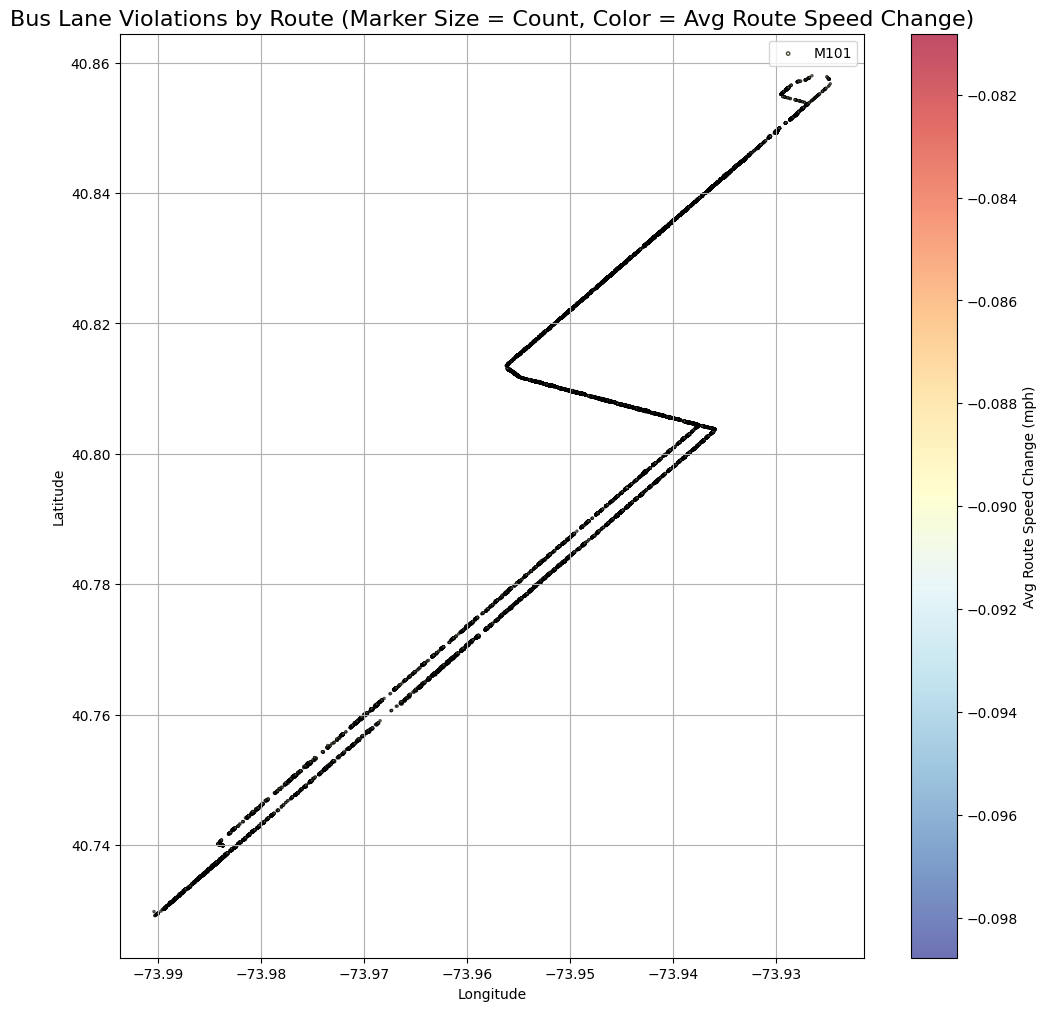

In [61]:
import matplotlib.pyplot as plt

# Aggregate violations by lat/lon and route
plot_data = violations.groupby(['route_id', 'violation_latitude', 'violation_longitude']).agg(
    violation_count=('violation_id','count')
).reset_index()

# Compute average speed delta per route (route-level)
route_speed_delta = merged_hotspots_clean.groupby('route_id')['speed_delta'].mean().to_dict()
plot_data['avg_speed_delta'] = plot_data['route_id'].map(route_speed_delta)

# Plot
routes = plot_data['route_id'].unique()
route_colors = {route: plt.cm.tab10(i) for i, route in enumerate(routes)}

plt.figure(figsize=(12,12))
for route in routes:
    subset = plot_data[plot_data['route_id'] == route]
    plt.scatter(
        subset['violation_longitude'],
        subset['violation_latitude'],
        s=subset['violation_count']*2,
        c=subset['avg_speed_delta'],
        cmap='RdYlBu_r',
        alpha=0.7,
        edgecolors='k',
        label=route
    )

plt.title("Bus Lane Violations by Route (Marker Size = Count, Color = Avg Route Speed Change)", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(label="Avg Route Speed Change (mph)")
plt.legend()
plt.grid(True)
plt.show()


In [72]:
import pandas as pd
import requests

# --- Helper to load JSON into DataFrame ---
def load_json_from_api(url):
    response = requests.get(url)
    return pd.DataFrame(response.json())

# --- API endpoints ---
url_speeds_2023 = "https://data.ny.gov/resource/58t6-89vi.json"
url_speeds_2025 = "https://data.ny.gov/resource/kufs-yh3x.json"
url_ace = "https://data.ny.gov/resource/kh8p-hcbm.json"

# --- Load datasets ---
speeds_2023_24 = load_json_from_api(url_speeds_2023)
speeds_2025 = load_json_from_api(url_speeds_2025)
ace_routes = load_json_from_api(url_ace)
violations = ace_routes.copy()  # Using ACE violation dataset

# --- Preprocess speeds ---
for df in [speeds_2023_24, speeds_2025]:
    df['avg_speed_mph'] = pd.to_numeric(df['average_road_speed'], errors='coerce')
    df['route_id'] = df['route_id'].astype(str)

# --- Preprocess ACE routes ---
ace_routes = ace_routes.rename(columns={'bus_route_id': 'route_id'})
ace_routes['route_id'] = ace_routes['route_id'].astype(str)

# --- Compute average speed per route ---
avg_speed_2023 = speeds_2023_24.groupby('route_id')['avg_speed_mph'].mean().reset_index()
avg_speed_2025 = speeds_2025.groupby('route_id')['avg_speed_mph'].mean().reset_index()

# --- Merge ACE info ---
avg_speed_combined = avg_speed_2023.merge(avg_speed_2025, on='route_id', how='outer', suffixes=('_2023_24', '_2025'))
avg_speed_combined['speed_improvement'] = avg_speed_combined['avg_speed_mph_2025'] - avg_speed_combined['avg_speed_mph_2023_24']

# --- Mark ACE vs Non-ACE ---
avg_speed_combined['is_ace'] = avg_speed_combined['route_id'].isin(ace_routes['route_id'])
avg_speed_combined['route_type'] = avg_speed_combined['is_ace'].map({True: 'ACE', False: 'Non-ACE'})

# --- Correct violations column for grouping ---
violations = violations.rename(columns={'bus_route_id': 'route_id'})
violations['route_id'] = violations['route_id'].astype(str)

# --- Compute violations per ACE route ---
violation_counts = violations.groupby('route_id').size().reset_index(name='violation_count')

# --- Merge violations with speeds ---
report = avg_speed_combined.merge(violation_counts, on='route_id', how='left')
report['violation_count'] = report['violation_count'].fillna(0).astype(int)

# --- Sort for readability ---
report = report.sort_values(by='speed_improvement', ascending=False).reset_index(drop=True)

# --- Output report ---
print("ACE vs Non-ACE Route Report:")
print(report[['route_id', 'route_type', 'avg_speed_mph_2023_24', 'avg_speed_mph_2025', 'speed_improvement', 'violation_count']])


ACE vs Non-ACE Route Report:
   route_id route_type  avg_speed_mph_2023_24  avg_speed_mph_2025  \
0      QM35    Non-ACE              11.027140           12.943468   
1     SIM31    Non-ACE               9.638860           10.490196   
2        B6    Non-ACE               8.049876            8.665450   
3      Q15A    Non-ACE               9.888778           10.378152   
4      BX42    Non-ACE              10.987998           11.408313   
5      QM31    Non-ACE              11.671909           12.042754   
6        M5    Non-ACE               6.726266            7.012514   
7       M11    Non-ACE               6.747574            6.963827   
8       QM5    Non-ACE              11.956075           12.136031   
9        M4        ACE               6.090057            6.252295   
10      QM6    Non-ACE              12.513459           12.569030   
11       Q8    Non-ACE               9.257539            9.302973   
12    SIM32    Non-ACE               9.112787            9.137027   
13   

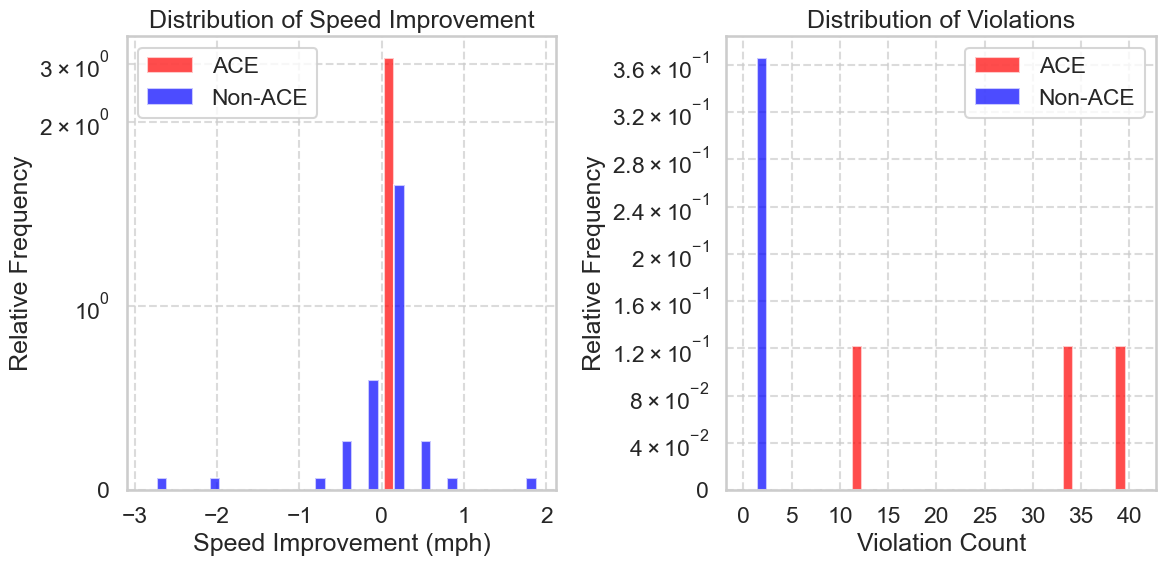

In [91]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Fill NaNs with 0 for plotting
plot_data = report.copy()
plot_data['speed_improvement'] = plot_data['speed_improvement'].fillna(0)
plot_data['violation_count'] = plot_data['violation_count'].fillna(0)

plt.figure(figsize=(12, 6))

# --- Histogram for speed improvement ---
plt.subplot(1, 2, 1)
plt.hist(
    [plot_data[plot_data['route_type'] == 'ACE']['speed_improvement'],
     plot_data[plot_data['route_type'] == 'Non-ACE']['speed_improvement']],
    bins=15,
    label=['ACE', 'Non-ACE'],
    color=['red', 'blue'],
    alpha=0.7,
    density=True
)
plt.xlabel("Speed Improvement (mph)")
plt.ylabel("Relative Frequency")
plt.title("Distribution of Speed Improvement")
plt.yscale('symlog')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, nbins=10))
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True, nbins=10))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# --- Histogram for violation count ---
plt.subplot(1, 2, 2)
plt.hist(
    [plot_data[plot_data['route_type'] == 'ACE']['violation_count'],
     plot_data[plot_data['route_type'] == 'Non-ACE']['violation_count']],
    bins=15,
    label=['ACE', 'Non-ACE'],
    color=['red', 'blue'],
    alpha=0.7,
    density=True
)
plt.xlabel("Violation Count")
plt.ylabel("Relative Frequency")
plt.title("Distribution of Violations")
plt.yscale('symlog')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, nbins=10))
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True, nbins=10))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()


In [96]:
import pandas as pd

# Load datasets with date parsing disabled (fixes FutureWarning)
df_2023 = pd.read_json("https://data.ny.gov/resource/58t6-89vi.json", convert_dates=False)
df_2025 = pd.read_json("https://data.ny.gov/resource/kufs-yh3x.json", convert_dates=False)
df_ace = pd.read_json("https://data.ny.gov/resource/kh8p-hcbm.json", convert_dates=False)

# --- Step 1: Compute baseline vs post-enforcement speeds ---
speeds_2023 = df_2023.groupby("route_id")["average_road_speed"].mean().reset_index()
speeds_2025 = df_2025.groupby("route_id")["average_road_speed"].mean().reset_index()

speeds = pd.merge(speeds_2023, speeds_2025, on="route_id", suffixes=("_2023", "_2025"))
speeds["speed_gain"] = speeds["average_road_speed_2025"] - speeds["average_road_speed_2023"]

# --- Step 2: Compute ACE violations intensity by route ---
ace_by_route = df_ace.groupby("bus_route_id")["violation_id"].count().reset_index()
ace_by_route = ace_by_route.rename(columns={"bus_route_id": "route_id", "violation_id": "violation_count"})

# --- Step 3: Merge datasets ---
merged = pd.merge(speeds, ace_by_route, on="route_id", how="inner")

# --- Step 4: Rank lists ---
top_violations = merged.sort_values("violation_count", ascending=False).head(10)
top_speed_gains = merged.sort_values("speed_gain", ascending=False).head(10)

overlap_routes = set(top_violations["route_id"]).intersection(set(top_speed_gains["route_id"]))
overlap_table = merged[merged["route_id"].isin(overlap_routes)][
    ["route_id", "violation_count", "speed_gain"]
].sort_values("violation_count", ascending=False)

# --- Step 5: Plain-English answer ---
if overlap_routes:
    print(f"Yes. There is partial alignment: {len(overlap_routes)} of the top 10 most ticketed routes "
          f"also rank in the top 10 for speed gains ({', '.join(overlap_routes)}).")
else:
    print("No clear alignment. The most ticketed routes do not significantly overlap with the "
          "ones showing the largest speed improvements in 2025.")

print("\n=== Top 10 Routes by ACE Violations ===")
display(top_violations[["route_id", "violation_count", "speed_gain"]])

print("\n=== Top 10 Routes by Speed Gain ===")
display(top_speed_gains[["route_id", "violation_count", "speed_gain"]])

print("\n=== Overlapping Routes (Both Top 10) ===")
display(overlap_table)


Yes. There is partial alignment: 1 of the top 10 most ticketed routes also rank in the top 10 for speed gains (M4).

=== Top 10 Routes by ACE Violations ===


,route_id,violation_count,speed_gain
0,M4,11,0.565668



=== Top 10 Routes by Speed Gain ===


,route_id,violation_count,speed_gain
0,M4,11,0.565668



=== Overlapping Routes (Both Top 10) ===


,route_id,violation_count,speed_gain
0,M4,11,0.565668


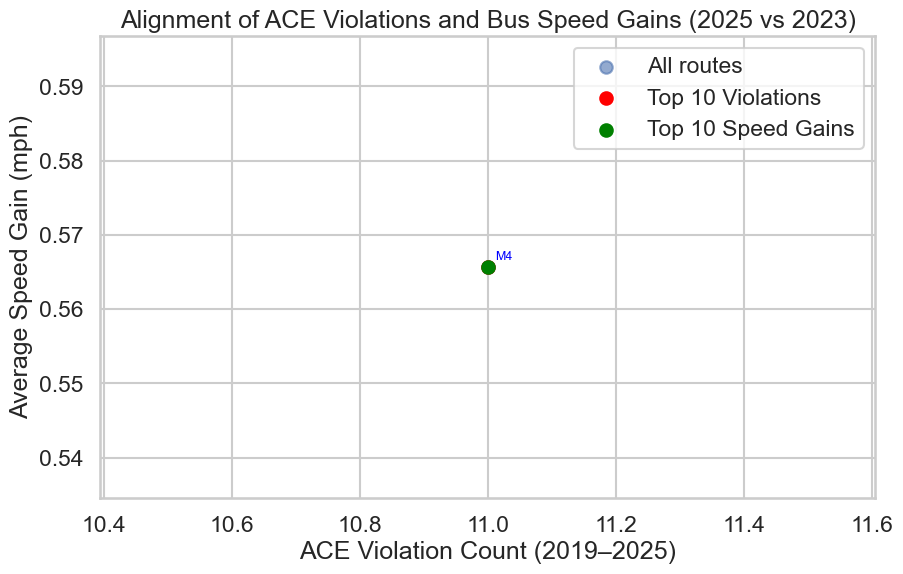

In [97]:
import matplotlib.pyplot as plt

# Scatterplot of all routes
plt.figure(figsize=(10,6))
plt.scatter(
    merged["violation_count"], 
    merged["speed_gain"], 
    alpha=0.6, 
    label="All routes"
)

# Highlight top 10 violators
plt.scatter(
    top_violations["violation_count"], 
    top_violations["speed_gain"], 
    color="red", 
    label="Top 10 Violations"
)

# Highlight top 10 speed gainers
plt.scatter(
    top_speed_gains["violation_count"], 
    top_speed_gains["speed_gain"], 
    color="green", 
    label="Top 10 Speed Gains"
)

# Annotate overlapping routes
for _, row in overlap_table.iterrows():
    plt.annotate(row["route_id"], (row["violation_count"], row["speed_gain"]),
                 textcoords="offset points", xytext=(5,5), fontsize=9, color="blue")

plt.title("Alignment of ACE Violations and Bus Speed Gains (2025 vs 2023)")
plt.xlabel("ACE Violation Count (2019–2025)")
plt.ylabel("Average Speed Gain (mph)")
plt.legend()
plt.grid(True)
plt.show()


In [101]:
import pandas as pd

# === Load datasets directly from APIs ===
url_speeds_2023 = "https://data.ny.gov/resource/58t6-89vi.json"
url_speeds_2025 = "https://data.ny.gov/resource/kufs-yh3x.json"
url_ace = "https://data.ny.gov/resource/kh8p-hcbm.json"

# Read JSON without automatic datetime parsing to avoid warnings
df_speeds_2023 = pd.read_json(url_speeds_2023, convert_dates=False)
df_speeds_2025 = pd.read_json(url_speeds_2025, convert_dates=False)
df_ace = pd.read_json(url_ace, convert_dates=False)

# --- Step 1: Aggregate ACE violations by borough ---
route_boroughs = df_speeds_2023[['route_id','borough']].drop_duplicates()
df_ace = df_ace.rename(columns={'bus_route_id':'route_id'})
ace_with_borough = pd.merge(df_ace, route_boroughs, on='route_id', how='left')
violations_by_borough = ace_with_borough.groupby('borough')['violation_id'].count().reset_index()
violations_by_borough = violations_by_borough.rename(columns={'violation_id':'violation_count'})

# --- Step 2: Compute average bus speed gains per borough ---
df_speeds_2023 = df_speeds_2023.rename(columns={'average_road_speed':'speed_2023'})
df_speeds_2025 = df_speeds_2025.rename(columns={'average_road_speed':'speed_2025'})
speeds_merged = pd.merge(
    df_speeds_2023[['route_id','stop_order','borough','speed_2023']],
    df_speeds_2025[['route_id','stop_order','borough','speed_2025']],
    on=['route_id','stop_order','borough'],
    how='inner'
)

# Fix: compute mean explicitly instead of using apply
borough_speed_change = (
    speeds_merged.groupby('borough')[['speed_2023','speed_2025']]
    .mean()
    .reset_index()
)
borough_speed_change['avg_speed_gain'] = borough_speed_change['speed_2025'] - borough_speed_change['speed_2023']

# --- Step 3: Combine into borough-level report ---
borough_report = pd.merge(violations_by_borough, borough_speed_change[['borough','avg_speed_gain']], on='borough', how='inner')

# --- Step 4: Generate plain-text report ---
report_lines = ["=== Equity & Rider Experience Across Boroughs ==="]
for _, row in borough_report.iterrows():
    report_lines.append(
        f"{row['borough']}: {row['violation_count']} violations, "
        f"avg speed gain = {row['avg_speed_gain']:.2f} mph"
    )

report_text = "\n".join(report_lines)
print(report_text)


=== Equity & Rider Experience Across Boroughs ===
Bronx: 33 violations, avg speed gain = -0.59 mph
Manhattan: 52 violations, avg speed gain = -0.08 mph


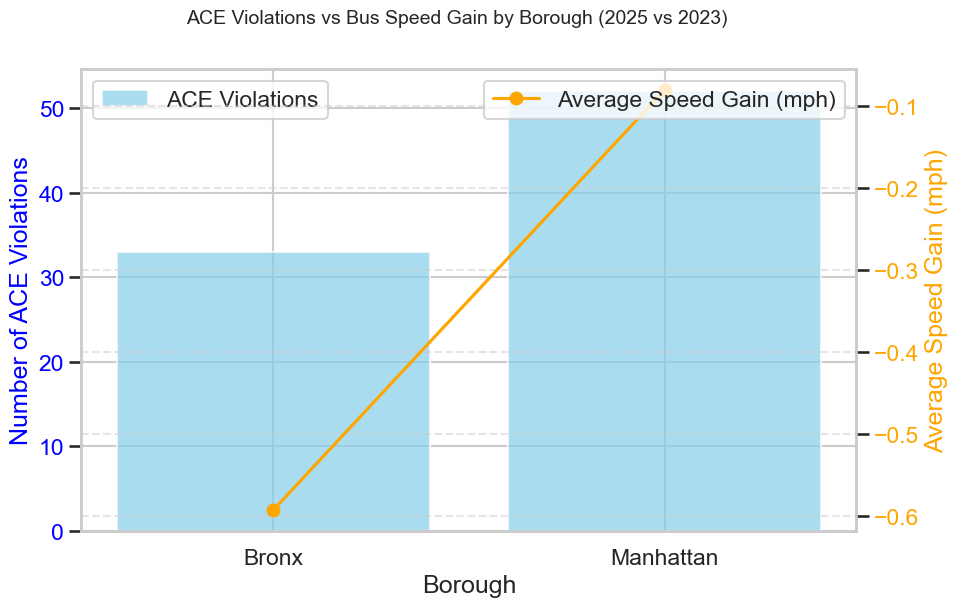

In [103]:
import pandas as pd
import matplotlib.pyplot as plt

# === Load datasets directly from APIs ===
url_speeds_2023 = "https://data.ny.gov/resource/58t6-89vi.json"
url_speeds_2025 = "https://data.ny.gov/resource/kufs-yh3x.json"
url_ace = "https://data.ny.gov/resource/kh8p-hcbm.json"

df_speeds_2023 = pd.read_json(url_speeds_2023, convert_dates=False)
df_speeds_2025 = pd.read_json(url_speeds_2025, convert_dates=False)
df_ace = pd.read_json(url_ace, convert_dates=False)

# --- Step 1: Aggregate ACE violations by borough ---
route_boroughs = df_speeds_2023[['route_id','borough']].drop_duplicates()
df_ace = df_ace.rename(columns={'bus_route_id':'route_id'})
ace_with_borough = pd.merge(df_ace, route_boroughs, on='route_id', how='left')
violations_by_borough = ace_with_borough.groupby('borough')['violation_id'].count().reset_index()
violations_by_borough = violations_by_borough.rename(columns={'violation_id':'violation_count'})

# --- Step 2: Compute average bus speed gains per borough ---
df_speeds_2023 = df_speeds_2023.rename(columns={'average_road_speed':'speed_2023'})
df_speeds_2025 = df_speeds_2025.rename(columns={'average_road_speed':'speed_2025'})
speeds_merged = pd.merge(
    df_speeds_2023[['route_id','stop_order','borough','speed_2023']],
    df_speeds_2025[['route_id','stop_order','borough','speed_2025']],
    on=['route_id','stop_order','borough'],
    how='inner'
)

borough_speed_change = (
    speeds_merged.groupby('borough')[['speed_2023','speed_2025']]
    .mean()
    .reset_index()
)
borough_speed_change['avg_speed_gain'] = borough_speed_change['speed_2025'] - borough_speed_change['speed_2023']

# --- Step 3: Merge for plotting ---
borough_report = pd.merge(violations_by_borough, borough_speed_change[['borough','avg_speed_gain']], on='borough', how='inner')

# --- Step 4: Plot ---
fig, ax1 = plt.subplots(figsize=(10,6))

# Blue bars: ACE violations
ax1.bar(borough_report['borough'], borough_report['violation_count'], color='skyblue', alpha=0.7, label='ACE Violations')
ax1.set_xlabel('Borough')
ax1.set_ylabel('Number of ACE Violations', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Orange line: Average speed gain
ax2 = ax1.twinx()
ax2.plot(borough_report['borough'], borough_report['avg_speed_gain'], color='orange', marker='o', label='Average Speed Gain (mph)')
ax2.set_ylabel('Average Speed Gain (mph)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Titles and legend
fig.suptitle('ACE Violations vs Bus Speed Gain by Borough (2025 vs 2023)', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


In [102]:
import pandas as pd

# Load datasets
url_speeds_2023 = "https://data.ny.gov/resource/58t6-89vi.json"
url_speeds_2025 = "https://data.ny.gov/resource/kufs-yh3x.json"
url_ace = "https://data.ny.gov/resource/kh8p-hcbm.json"

df_2023 = pd.read_json(url_speeds_2023)
df_2025 = pd.read_json(url_speeds_2025)
df_ace = pd.read_json(url_ace)

# Step 1: Inspect column names so we know what to group by
print("=== 2023 Speeds Columns ===")
print(df_2023.columns.tolist(), "\n")

print("=== 2025 Speeds Columns ===")
print(df_2025.columns.tolist(), "\n")

print("=== ACE Violations Columns ===")
print(df_ace.columns.tolist(), "\n")

# Next step after we know the correct names:
# - Find the column for route identifier (likely 'route_id' or 'bus_route')
# - Find the speed column (likely 'segment_speed' or similar)
# -


C:\Users\User\AppData\Local\Temp\ipykernel_31444\2437545461.py:8: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df_2023 = pd.read_json(url_speeds_2023)
C:\Users\User\AppData\Local\Temp\ipykernel_31444\2437545461.py:9: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df_2025 = pd.read_json(url_speeds_2025)


=== 2023 Speeds Columns ===
['year', 'month', 'timestamp', 'day_of_week', 'hour_of_day', 'route_id', 'direction', 'borough', 'route_type', 'stop_order', 'timepoint_stop_id', 'timepoint_stop_name', 'timepoint_stop_latitude', 'timepoint_stop_longitude', 'next_timepoint_stop_id', 'next_timepoint_stop_name', 'next_timepoint_stop_latitude', 'next_timepoint_stop_longitude', 'road_distance', 'average_travel_time', 'average_road_speed', 'bus_trip_count', 'timepoint_stop_georeference', 'next_timepoint_stop_georeference'] 

=== 2025 Speeds Columns ===
['year', 'month', 'timestamp', 'day_of_week', 'hour_of_day', 'route_id', 'direction', 'borough', 'route_type', 'stop_order', 'timepoint_stop_id', 'timepoint_stop_name', 'timepoint_stop_latitude', 'timepoint_stop_longitude', 'next_timepoint_stop_id', 'next_timepoint_stop_name', 'next_timepoint_stop_latitude', 'next_timepoint_stop_longitude', 'road_distance', 'average_travel_time', 'average_road_speed', 'bus_trip_count', 'timepoint_stop_georeference'